In [ ]:
!pip install timm pytorch_lightning

# Download Dataset

In [2]:
# Setup Account file
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot create regular file '/root/.kaggle/': Not a directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
%%bash 

mkdir /root/.kaggle
cp kaggle.json /root/.kaggle/

In [10]:
!chmod 600 /root/.kaggle/kaggle.json

In [4]:
# create new directory
![[ ! -d "../input" ]] && rm -r ../input
!mkdir -p ../input/mayo-clinic-strip-ai

rm: cannot remove '../input': No such file or directory


In [5]:
%%bash

kaggle competitions download -c mayo-clinic-strip-ai -p ../input/mayo-clinic-strip-ai -f train.csv
kaggle competitions download -c mayo-clinic-strip-ai -p ../input/mayo-clinic-strip-ai -f test.csv
kaggle competitions download -c mayo-clinic-strip-ai -p ../input/mayo-clinic-strip-ai -f sample_submission.csv

100%|██████████| 17.5k/17.5k [00:00<00:00, 18.1MB/s]
100%|██████████| 124/124 [00:00<00:00, 135kB/s]
100%|██████████| 78.0/78.0 [00:00<00:00, 87.7kB/s]


In [6]:
%%bash

# DOWNLOAD TEST DIRECTORY

mkdir ../input/mayo-clinic-strip-ai/test

kaggle competitions files -c mayo-clinic-strip-ai | grep test/ | awk '{print $1}' \
 | while read x ; do kaggle competitions download -f $x mayo-clinic-strip-ai -p ../input/mayo-clinic-strip-ai/test ; done

for filename in ../input/mayo-clinic-strip-ai/test/*.zip; do
  unzip ${filename} -d ../input/mayo-clinic-strip-ai/test
  rm ${filename}
done





Archive:  ../input/mayo-clinic-strip-ai/test/006388_0.tif.zip
  inflating: ../input/mayo-clinic-strip-ai/test/006388_0.tif  
Archive:  ../input/mayo-clinic-strip-ai/test/008e5c_0.tif.zip
  inflating: ../input/mayo-clinic-strip-ai/test/008e5c_0.tif  
Archive:  ../input/mayo-clinic-strip-ai/test/00c058_0.tif.zip
  inflating: ../input/mayo-clinic-strip-ai/test/00c058_0.tif  
Archive:  ../input/mayo-clinic-strip-ai/test/01adc5_0.tif.zip
  inflating: ../input/mayo-clinic-strip-ai/test/01adc5_0.tif  


100%|██████████| 102M/102M [00:01<00:00, 102MB/s]  
100%|██████████| 645M/645M [00:04<00:00, 153MB/s]
100%|██████████| 322M/322M [00:06<00:00, 53.3MB/s]
100%|██████████| 1.20G/1.20G [00:13<00:00, 95.7MB/s]


In [ ]:
%%bash

# Download dataset from kaggle
[[ ! -e /content/strip-ai-tiles.zip ]] && kaggle datasets download djagatiya/strip-ai-tiles
[[ ! -d "../input/strip-ai-tiles" ]] && unzip /content/strip-ai-tiles.zip -d ../input/strip-ai-tiles

In [52]:
test_num = 501

# Training

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from PIL import Image

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import pytorch_lightning as pl


import torch
import random

plt.style.use("dark_background")

In [54]:
train_df = pd.read_csv("../input/mayo-clinic-strip-ai/train.csv")
test_df = pd.read_csv("../input/mayo-clinic-strip-ai/test.csv")
# other_df = pd.read_csv("../input/mayo-clinic-strip-ai/other.csv")

In [55]:
train_df.head()

,image_id,center_id,patient_id,image_num,label
0,006388_0,11,006388,0,CE
1,008e5c_0,11,008e5c,0,CE
2,00c058_0,11,00c058,0,LAA
3,01adc5_0,11,01adc5,0,LAA
4,026c97_0,4,026c97,0,CE


In [56]:
test_df.head()

,image_id,center_id,patient_id,image_num
0,006388_0,11,006388,0
1,008e5c_0,11,008e5c,0
2,00c058_0,11,00c058,0
3,01adc5_0,11,01adc5,0


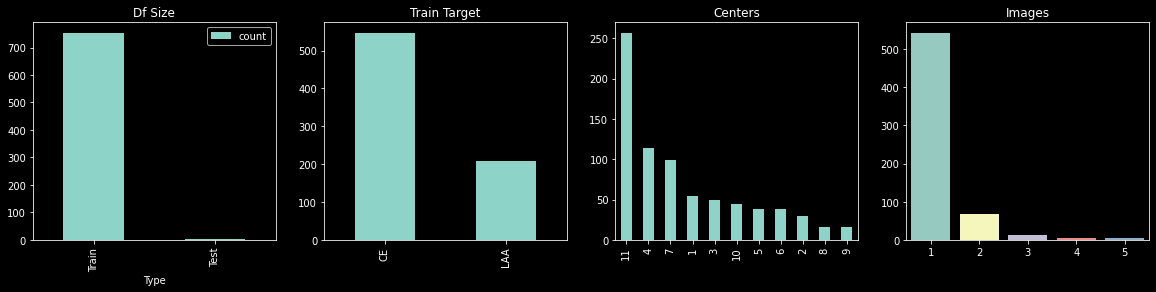

In [57]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,4))

train_df.label.value_counts().plot(kind='bar', ax=axes[1], title='Train Target')
train_df.center_id.value_counts().plot(kind='bar', ax=axes[2], title='Centers')

number_img, num_patients = np.unique(train_df.patient_id.value_counts().values, return_counts=True)

sns.barplot(x=number_img, y=num_patients, ax=axes[3]).set_title('Images')

pd.DataFrame.from_dict([
    {
        "Type" : "Train",
        "count": len(train_df)
    },
    {
        "Type" : "Test",
        "count": len(test_df)
    },
    # {
    #     "Type" : "Other",
    #     "count": len(other_df)
    # }
]).set_index('Type').plot(kind='bar', ax=axes[0], title='Df Size')

plt.show()

In [58]:
train_df['image_path'] = train_df.image_id.apply(lambda x : f"../input/mayo-clinic-strip-ai/train/{x}.tif")

In [59]:
train_df.head()

,image_id,center_id,patient_id,image_num,label,image_path
0,006388_0,11,006388,0,CE,../input/mayo-clinic-strip-ai/train/006388_0.tif
1,008e5c_0,11,008e5c,0,CE,../input/mayo-clinic-strip-ai/train/008e5c_0.tif
2,00c058_0,11,00c058,0,LAA,../input/mayo-clinic-strip-ai/train/00c058_0.tif
3,01adc5_0,11,01adc5,0,LAA,../input/mayo-clinic-strip-ai/train/01adc5_0.tif
4,026c97_0,4,026c97,0,CE,../input/mayo-clinic-strip-ai/train/026c97_0.tif


In [60]:
train_tiles_df = pd.read_csv("../input/strip-ai-tiles/train_df_tiles.csv")
train_tiles_df = train_tiles_df[['image_id','tile_ids']]

In [61]:
train_tiles_df.head()

,image_id,tile_ids
0,006388_0,"[1, 2, 3, 8, 23, 27, 28, 31, 33, 38]"
1,008e5c_0,"[2, 3, 7, 8, 12, 22, 96, 102, 111, 116]"
2,00c058_0,"[5, 11, 16, 22, 26, 71, 77, 82, 88, 92]"
3,01adc5_0,"[0, 10, 11, 15, 21, 25, 29, 35, 39, 49]"
4,026c97_0,"[1, 7, 8, 9, 15, 16, 17, 22, 23, 28]"


In [62]:
train_df = pd.merge(train_df, train_tiles_df, on=['image_id'])
display(train_df.head())

,image_id,center_id,patient_id,image_num,label,image_path,tile_ids
0,006388_0,11,006388,0,CE,../input/mayo-clinic-strip-ai/train/006388_0.tif,"[1, 2, 3, 8, 23, 27, 28, 31, 33, 38]"
1,008e5c_0,11,008e5c,0,CE,../input/mayo-clinic-strip-ai/train/008e5c_0.tif,"[2, 3, 7, 8, 12, 22, 96, 102, 111, 116]"
2,00c058_0,11,00c058,0,LAA,../input/mayo-clinic-strip-ai/train/00c058_0.tif,"[5, 11, 16, 22, 26, 71, 77, 82, 88, 92]"
3,01adc5_0,11,01adc5,0,LAA,../input/mayo-clinic-strip-ai/train/01adc5_0.tif,"[0, 10, 11, 15, 21, 25, 29, 35, 39, 49]"
4,026c97_0,4,026c97,0,CE,../input/mayo-clinic-strip-ai/train/026c97_0.tif,"[1, 7, 8, 9, 15, 16, 17, 22, 23, 28]"


In [63]:
def display_tiles(row):
#     print(row)
    tile_ids = eval(row.tile_ids)
     
    fig, ax_ls = plt.subplots(1, len(tile_ids), figsize=(20,4))
    
    for i, tile_id in enumerate(tile_ids):
        path = f"../input/strip-ai-tiles/tiles/{row.image_id}.{tile_id}.png"
        img = Image.open(path)
        ax_ls[i].imshow(img)
        ax_ls[i].axis('off')
    
    plt.show()

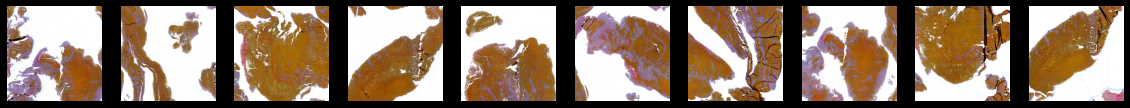

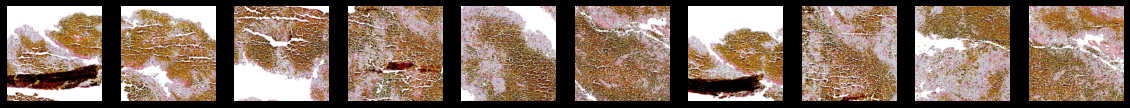

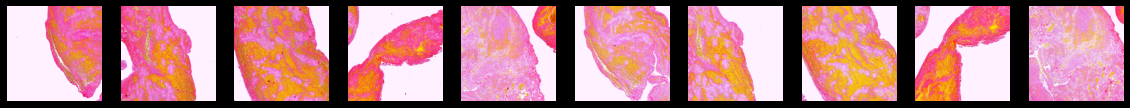

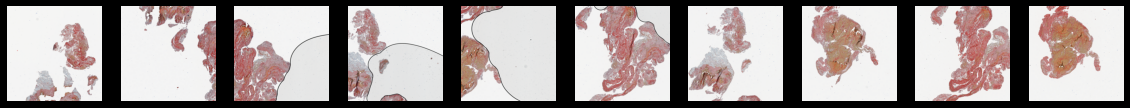

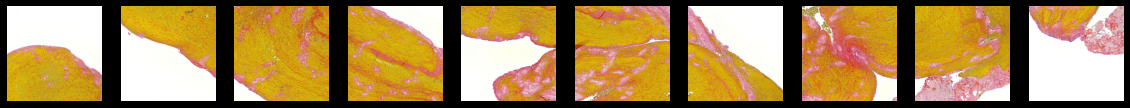

In [64]:
for i in range(5):
  display_tiles(train_df.iloc[i])

In [65]:
train_df_CE = train_df[train_df.label == 'CE']
train_df_LAA = train_df[train_df.label == 'LAA']

train_df_CE.shape, train_df_LAA.shape

((547, 7), (207, 7))

In [66]:
train_df_LAA_upsampled = resample(train_df_LAA,
                                 replace=True,    # sample with replacement
                                 n_samples= 547, # to match majority class
                                 random_state=42)  # reproducible results

In [67]:
train_df_LAA_upsampled.shape

(547, 7)

In [68]:
train_df = pd.concat([train_df_CE, train_df_LAA_upsampled])
train_df.shape

(1094, 7)

In [69]:
train_df.label.value_counts()

CE     547
LAA    547
Name: label, dtype: int64

In [70]:
train_split_df, val_split_df = train_test_split(train_df, random_state=2022)
train_split_df.shape, val_split_df.shape

((820, 7), (274, 7))

In [71]:
train_split_df.label.value_counts()

CE     414
LAA    406
Name: label, dtype: int64

In [72]:
val_split_df.label.value_counts()

LAA    141
CE     133
Name: label, dtype: int64

In [73]:
import torch
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader

In [74]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [75]:
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [76]:
class TilesDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, df, transform):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        
        row = self.df.iloc[idx]
        
        images = []
        
        tile_ids = eval(row.tile_ids)
        for tile_id in tile_ids:
            path = f"../input/strip-ai-tiles/tiles/{row.image_id}.{tile_id}.png"
            img = Image.open(path)
            images.append(img)
            
        images = [self.transform(i) for i in images]
        label = [0] if row.label == 'CE' else [1]
        
        images = torch.stack(images)
        
        label = torch.Tensor(label)
        
        return images, label

In [77]:
train_split_ds = TilesDataset(train_split_df, train_transform)
print(len(train_split_ds))

demo_arr = train_split_ds[0][0]
demo_arr.shape, demo_arr.min(), demo_arr.max()

820


(torch.Size([10, 3, 224, 224]), tensor(-2.0357), tensor(2.6400))

In [78]:
import torch.nn as nn
import timm
import torch.optim as optim
import torch.nn.functional as F

In [79]:
def get_positional_embedding(s_len, d):
    result = torch.ones(s_len, d)
    for i in range(s_len):
        for j in range(d):
            if j % 2 == 0:
                result[i][j] = np.sin(i / (10000 ** (j / d)))
            else:
                result[i][j] = np.cos(i / (10000 ** ((j-1) / d)))
    return result 

In [80]:
model = timm.create_model("efficientnet_b0", pretrained=True, num_classes=0)
for i, _children in enumerate(model.children()):
    print(i, type(_children))

0 <class 'torch.nn.modules.conv.Conv2d'>
1 <class 'timm.models.layers.norm_act.BatchNormAct2d'>
2 <class 'torch.nn.modules.container.Sequential'>
3 <class 'torch.nn.modules.conv.Conv2d'>
4 <class 'timm.models.layers.norm_act.BatchNormAct2d'>
5 <class 'timm.models.layers.adaptive_avgmax_pool.SelectAdaptivePool2d'>
6 <class 'torch.nn.modules.linear.Identity'>


In [81]:
import math

def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0.0, std=0.01)
        # nn.init.kaiming_uniform_(m.weight.data)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Parameter):
        nn.init.normal_(m, mean=0.0, std=0.01)

In [82]:
class AttentionCust(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, attn_drop=0., proj_drop=0.):
        super().__init__()
        assert dim % num_heads == 0, 'dim should be divisible by num_heads'
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        initialize_weights(self.qkv)
        initialize_weights(self.proj)


    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)   # make torchscript happy (cannot use tensor as tuple)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

In [83]:
class TileVit(nn.Module):

    def __init__(self) -> None:
        super().__init__()

        self.num_patches = 10
        self.model = timm.create_model("efficientnet_b0", pretrained=True, num_classes=0)
        for i, _children in enumerate(self.model.children()):
            print(i, type(_children))
            if i <= 1000:
                print("Freezing Layer....")
                for param in _children.parameters():
                    param.requires_grad = False
                
        self.embed = 128

        self.linear_mapper = nn.Linear(1280, self.embed)

        self.attention = AttentionCust(self.embed, 2)
        self.class_token = nn.Parameter(torch.rand(1, self.embed))

        self.last_layer = nn.Linear(self.embed, 1)


        # [RANDOM INIT]
        initialize_weights(self.linear_mapper)
        initialize_weights(self.last_layer)
        # initialize_weights(self.class_token)


    def forward(self, x):

        n, pa, c, w, h = x.shape

        # (1) - Featues extraction
        x = x.reshape(-1, 3, 224, 224)
        x = self.model(x)

        # (2) projection -> 64
        tokens = self.linear_mapper(x)

        tokens = tokens.reshape(-1, pa, self.embed)

        # (3) adding class token
        tokens = torch.stack([torch.vstack([self.class_token, tokens[i]]) for i in range(len(tokens))])

        # (4) adding positional embedding
        # tokens += get_positional_embedding(11, self.embed).repeat(n, 1, 1).to('cuda')

        tokens = self.attention(tokens)

        tokens = tokens[:, 0]

        tokens = self.last_layer(tokens)
        
        return tokens

In [84]:
class TileVitModule(pl.LightningModule):

    def __init__(self):
        super().__init__()
        self.model = TileVit()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = F.binary_cross_entropy_with_logits(y_hat, y)
        self.log("train_loss", loss)
        return loss

    def on_train_epoch_start(self):
        print("Epoch:", self.current_epoch)

    def training_epoch_end(self, training_step_outputs):
        loss = torch.stack([o['loss'] for o in training_step_outputs]).cpu().mean()
        print("Training Loss:", loss)

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = F.binary_cross_entropy_with_logits(y_hat, y)
        self.log("val_loss", loss)
        return loss


    def validation_epoch_end(self, validation_step_outputs):
        loss = torch.stack(validation_step_outputs).cpu().mean()
        print("Validation Loss:", loss)


    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=0.001)
        # scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.1)
        # return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}
        return optimizer


In [85]:
from pytorch_lightning.callbacks import TQDMProgressBar, ModelCheckpoint

In [86]:
# FIX SEED
random.seed(0)
torch.manual_seed(0)
np.random.seed(0)
pl.seed_everything(0)

model = TileVitModule()

train_split_loader = DataLoader(train_split_ds,batch_size=8, shuffle=True)

val_split_ds = TilesDataset(val_split_df, val_transform)
val_split_loader = DataLoader(val_split_ds,batch_size=8)

test_num += 1

dirpath = f'/content/train_{test_num}'
print("Saved AT:", dirpath)


checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath=dirpath,
    filename='sample-mnist-{epoch:02d}-{val_loss:.4f}',
    save_top_k=2
)

trainer = pl.Trainer(
    accelerator="auto", 
    max_epochs=50,
    callbacks=[TQDMProgressBar(refresh_rate=2), checkpoint_callback]
)

trainer.fit(model, train_dataloaders=train_split_loader, val_dataloaders=val_split_loader)

INFO:pytorch_lightning.utilities.seed:Global seed set to 0


0 <class 'torch.nn.modules.conv.Conv2d'>
Freezing Layer....
1 <class 'timm.models.layers.norm_act.BatchNormAct2d'>
Freezing Layer....
2 <class 'torch.nn.modules.container.Sequential'>
Freezing Layer....
3 <class 'torch.nn.modules.conv.Conv2d'>
Freezing Layer....
4 <class 'timm.models.layers.norm_act.BatchNormAct2d'>
Freezing Layer....
5 <class 'timm.models.layers.adaptive_avgmax_pool.SelectAdaptivePool2d'>
Freezing Layer....
6 <class 'torch.nn.modules.linear.Identity'>
Freezing Layer....
Saved AT: /content/train_502


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type    | Params
----------------------------------
0 | model | TileVit | 4.2 M 
----------------------------------
229 K     Trainable params
4.0 M     Non-trainable params
4.2 M     Total params
16.950    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Validation Loss: tensor(0.6931)


Training: 0it [00:00, ?it/s]

Epoch: 0


Validation: 0it [00:00, ?it/s]

Validation Loss: tensor(0.6864)
Training Loss: tensor(0.6937)
Epoch: 1


Validation: 0it [00:00, ?it/s]

Validation Loss: tensor(0.6659)
Training Loss: tensor(0.6802)
Epoch: 2


Validation: 0it [00:00, ?it/s]

Validation Loss: tensor(0.6378)
Training Loss: tensor(0.6432)
Epoch: 3


Validation: 0it [00:00, ?it/s]

Validation Loss: tensor(0.6100)
Training Loss: tensor(0.6056)
Epoch: 4


Validation: 0it [00:00, ?it/s]

Validation Loss: tensor(0.6070)
Training Loss: tensor(0.5801)
Epoch: 5


Validation: 0it [00:00, ?it/s]

Validation Loss: tensor(0.5920)
Training Loss: tensor(0.5421)
Epoch: 6


Validation: 0it [00:00, ?it/s]

Validation Loss: tensor(0.5812)
Training Loss: tensor(0.5246)
Epoch: 7


Validation: 0it [00:00, ?it/s]

Validation Loss: tensor(0.5865)
Training Loss: tensor(0.4926)
Epoch: 8


Validation: 0it [00:00, ?it/s]

Validation Loss: tensor(0.5874)
Training Loss: tensor(0.4902)
Epoch: 9


Validation: 0it [00:00, ?it/s]

Validation Loss: tensor(0.6124)
Training Loss: tensor(0.4756)
Epoch: 10


Validation: 0it [00:00, ?it/s]

Validation Loss: tensor(0.5238)
Training Loss: tensor(0.4940)
Epoch: 11


Validation: 0it [00:00, ?it/s]

Validation Loss: tensor(0.5494)
Training Loss: tensor(0.4306)
Epoch: 12


Validation: 0it [00:00, ?it/s]

Validation Loss: tensor(0.5094)
Training Loss: tensor(0.4201)
Epoch: 13


Validation: 0it [00:00, ?it/s]

Validation Loss: tensor(0.5439)
Training Loss: tensor(0.3993)
Epoch: 14


Validation: 0it [00:00, ?it/s]

Validation Loss: tensor(0.5053)
Training Loss: tensor(0.4202)
Epoch: 15


Validation: 0it [00:00, ?it/s]

Validation Loss: tensor(0.5353)
Training Loss: tensor(0.4222)
Epoch: 16


Validation: 0it [00:00, ?it/s]

Validation Loss: tensor(0.4989)
Training Loss: tensor(0.3645)
Epoch: 17


Validation: 0it [00:00, ?it/s]

Validation Loss: tensor(0.4554)
Training Loss: tensor(0.3939)
Epoch: 18


Validation: 0it [00:00, ?it/s]

Validation Loss: tensor(0.6356)
Training Loss: tensor(0.3265)
Epoch: 19


Validation: 0it [00:00, ?it/s]

Validation Loss: tensor(0.5757)
Training Loss: tensor(0.3197)
Epoch: 20


Validation: 0it [00:00, ?it/s]

Validation Loss: tensor(0.5118)
Training Loss: tensor(0.3352)
Epoch: 21


Validation: 0it [00:00, ?it/s]

Validation Loss: tensor(0.4683)
Training Loss: tensor(0.3229)
Epoch: 22


Validation: 0it [00:00, ?it/s]

Validation Loss: tensor(0.5688)
Training Loss: tensor(0.2691)
Epoch: 23


Validation: 0it [00:00, ?it/s]

Validation Loss: tensor(0.4849)
Training Loss: tensor(0.2880)
Epoch: 24


Validation: 0it [00:00, ?it/s]

Validation Loss: tensor(0.4596)
Training Loss: tensor(0.2684)
Epoch: 25


Validation: 0it [00:00, ?it/s]

Validation Loss: tensor(0.4599)
Training Loss: tensor(0.2856)
Epoch: 26


Validation: 0it [00:00, ?it/s]

Validation Loss: tensor(0.5659)
Training Loss: tensor(0.3189)
Epoch: 27


Validation: 0it [00:00, ?it/s]

Validation Loss: tensor(0.5086)
Training Loss: tensor(0.2370)
Epoch: 28


Validation: 0it [00:00, ?it/s]

Validation Loss: tensor(0.6000)
Training Loss: tensor(0.2574)
Epoch: 29


Validation: 0it [00:00, ?it/s]

Validation Loss: tensor(0.6225)
Training Loss: tensor(0.2804)
Epoch: 30


Validation: 0it [00:00, ?it/s]

Validation Loss: tensor(0.4555)
Training Loss: tensor(0.2507)
Epoch: 31


Validation: 0it [00:00, ?it/s]

Validation Loss: tensor(0.4393)
Training Loss: tensor(0.2686)
Epoch: 32


Validation: 0it [00:00, ?it/s]

Validation Loss: tensor(0.4220)
Training Loss: tensor(0.2686)
Epoch: 33


Validation: 0it [00:00, ?it/s]

Validation Loss: tensor(0.4103)
Training Loss: tensor(0.2844)
Epoch: 34


Validation: 0it [00:00, ?it/s]

Validation Loss: tensor(0.4403)
Training Loss: tensor(0.2525)
Epoch: 35


Validation: 0it [00:00, ?it/s]

Validation Loss: tensor(0.4649)
Training Loss: tensor(0.2203)
Epoch: 36


Validation: 0it [00:00, ?it/s]

Validation Loss: tensor(0.6454)
Training Loss: tensor(0.2353)
Epoch: 37


Validation: 0it [00:00, ?it/s]

Validation Loss: tensor(0.5039)
Training Loss: tensor(0.2394)
Epoch: 38


Validation: 0it [00:00, ?it/s]

Validation Loss: tensor(0.4508)
Training Loss: tensor(0.1928)
Epoch: 39


Validation: 0it [00:00, ?it/s]

Validation Loss: tensor(0.4495)
Training Loss: tensor(0.2204)
Epoch: 40


Validation: 0it [00:00, ?it/s]

Validation Loss: tensor(0.3720)
Training Loss: tensor(0.2050)
Epoch: 41


Validation: 0it [00:00, ?it/s]

Validation Loss: tensor(0.5397)
Training Loss: tensor(0.1649)
Epoch: 42


Validation: 0it [00:00, ?it/s]

Validation Loss: tensor(0.4893)
Training Loss: tensor(0.1387)
Epoch: 43


Validation: 0it [00:00, ?it/s]

Validation Loss: tensor(0.5279)
Training Loss: tensor(0.1671)
Epoch: 44


Validation: 0it [00:00, ?it/s]

Validation Loss: tensor(0.4568)
Training Loss: tensor(0.1865)
Epoch: 45


Validation: 0it [00:00, ?it/s]

Validation Loss: tensor(0.4936)
Training Loss: tensor(0.1592)
Epoch: 46


Validation: 0it [00:00, ?it/s]

Validation Loss: tensor(0.4441)
Training Loss: tensor(0.1585)
Epoch: 47


Validation: 0it [00:00, ?it/s]

Validation Loss: tensor(0.3943)
Training Loss: tensor(0.1720)
Epoch: 48


Validation: 0it [00:00, ?it/s]

Validation Loss: tensor(0.3533)
Training Loss: tensor(0.1807)
Epoch: 49


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


Validation Loss: tensor(0.5414)
Training Loss: tensor(0.1190)


```
Epoch: 0
Validation Loss: tensor(0.7478)
Training Loss: tensor(0.6900)
Epoch: 1
Validation Loss: tensor(0.6747)
Training Loss: tensor(0.7020)
Epoch: 2
Validation Loss: tensor(0.6260)
Training Loss: tensor(0.6620)
Epoch: 3
Validation Loss: tensor(0.6493)
Training Loss: tensor(0.6442)
Epoch: 4
Validation Loss: tensor(0.5518)
Training Loss: tensor(0.5882)
Epoch: 5
Validation Loss: tensor(0.5191)
Training Loss: tensor(0.5366)
Epoch: 6
Validation Loss: tensor(0.5328)
Training Loss: tensor(0.4664)
Epoch: 7
Validation Loss: tensor(0.5383)
Training Loss: tensor(0.4025)
Epoch: 8
Validation Loss: tensor(0.4578)
Training Loss: tensor(0.3967)
Epoch: 9
Validation Loss: tensor(0.4895)
Training Loss: tensor(0.3934)
Epoch: 10
Validation Loss: tensor(0.5193)
Training Loss: tensor(0.3340)
Epoch: 11
Validation Loss: tensor(0.4829)
Training Loss: tensor(0.2955)
Epoch: 12
Validation Loss: tensor(0.4226)
Training Loss: tensor(0.3017)
Epoch: 13
Validation Loss: tensor(0.5284)
Training Loss: tensor(0.2793)
Epoch: 14
Validation Loss: tensor(0.4315)
Training Loss: tensor(0.2833)
Epoch: 15
Validation Loss: tensor(0.5125)
Training Loss: tensor(0.2885)
Epoch: 16
Validation Loss: tensor(0.4788)
Training Loss: tensor(0.2682)
Epoch: 17
Validation Loss: tensor(0.7022)
Training Loss: tensor(0.2567)
```

In [94]:
loaded = TileVitModule.load_from_checkpoint("/content/train_502/sample-mnist-epoch=48-val_loss=0.3604.ckpt")

val_split_ds = TilesDataset(val_split_df, val_transform)
print(len(val_split_ds))
val_split_loader = DataLoader(val_split_ds,batch_size=8)

loaded.to('cuda')
loaded.eval()

true_ls = []
pred_ls = []

for i, data in enumerate(val_split_loader, 0):
    inputs, labels = data
    inputs = inputs.to('cuda')
    
    with torch.no_grad():
        pred = loaded(inputs).cpu()
        
    pred = torch.sigmoid(pred).numpy().ravel().tolist()
    labels = labels.numpy().ravel().tolist()
    
    true_ls.extend(labels)
    pred_ls.extend(pred)

0 <class 'torch.nn.modules.conv.Conv2d'>
Freezing Layer....
1 <class 'timm.models.layers.norm_act.BatchNormAct2d'>
Freezing Layer....
2 <class 'torch.nn.modules.container.Sequential'>
Freezing Layer....
3 <class 'torch.nn.modules.conv.Conv2d'>
Freezing Layer....
4 <class 'timm.models.layers.norm_act.BatchNormAct2d'>
Freezing Layer....
5 <class 'timm.models.layers.adaptive_avgmax_pool.SelectAdaptivePool2d'>
Freezing Layer....
6 <class 'torch.nn.modules.linear.Identity'>
Freezing Layer....
274


In [98]:
true_np = np.array(true_ls)
pred_np = np.array(pred_ls)
true_np.shape, pred_np.shape

threash = 0.6

pred_np[pred_np > threash] = 1
pred_np[pred_np < threash] = 0

In [99]:
confusion_matrix(true_np, pred_np)

array([[116,  17],
       [ 16, 125]])

In [100]:
print(classification_report(true_np, pred_np))

              precision    recall  f1-score   support

         0.0       0.88      0.87      0.88       133
         1.0       0.88      0.89      0.88       141

    accuracy                           0.88       274
   macro avg       0.88      0.88      0.88       274
weighted avg       0.88      0.88      0.88       274



In [ ]:
1# %load_ext tensorboard

1

In [ ]:
# %tensorboard --logdir /content/lightning_logs